In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.contrib.learn as learn
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from pymongo import MongoClient
import ystockquote

In [4]:
from datetime import datetime, timedelta, timezone
import pytz
import math

# Load transcripts

In [5]:
est_tz = pytz.timezone('US/Eastern')
def utc_to_est(utc_dt):
    local_dt = utc_dt.replace(tzinfo=pytz.utc).astimezone(est_tz)
    return est_tz.normalize(local_dt)

In [6]:
def shift_time_according_to_closing_time(dt):
    if dt.hour >= 16:
        return dt + timedelta(days=1)
    return dt

In [7]:
def load_and_clean_transcripts():
    client = MongoClient('localhost', 27017)
    earnings_transcript_collection = client.python_import.earnings_transcript
    
    earnings_transcript = pd.DataFrame(list(earnings_transcript_collection.find()))
    earnings_transcript.drop('_id', axis=1, inplace=True)
    earnings_transcript['shifted_publishDate'] = earnings_transcript.apply(
        lambda row: datetime.strptime(row['publishDate'], '%Y-%m-%dT%H:%M:%SZ'), axis=1
    )
    earnings_transcript['shifted_publishDate'] = earnings_transcript.apply(
        lambda row: utc_to_est(row['shifted_publishDate']), axis=1
    )
    earnings_transcript['shifted_publishDate'] = earnings_transcript.apply(
        lambda row: shift_time_according_to_closing_time(row['shifted_publishDate']), axis=1
    )
    earnings_transcript['publishDate_str'] = earnings_transcript.apply(
        lambda row: str(row['shifted_publishDate'].date()), axis=1
    )
    earnings_transcript.set_index(['tradingSymbol', 'publishDate_str'], inplace=True)
    
    return earnings_transcript

In [8]:
earnings_transcript = load_and_clean_transcripts()

In [9]:
earnings_transcript.head(2)

,,publishDate,qAndAText,rawText,url,shifted_publishDate
tradingSymbol,publishDate_str,,,,,
A,2014-11-18,2014-11-17T22:25:00Z,,The following audio is from a conference call ...,https://seekingalpha.com/article/2675895-agile...,2014-11-18 17:25:00-05:00
AA,2014-10-09,2014-10-09T01:18:03Z,Operator [Operator instructions.] Our first qu...,Alcoa (NYSE: AA ) Q3 2014 Results Earnings Con...,https://seekingalpha.com/article/2549515-alcoa...,2014-10-09 21:18:03-04:00


In [10]:
earnings_transcript.tail(2)

publishDate qAndAText  \
tradingSymbol publishDate_str                                   
AGCO          2008-07-30       2008-07-29T22:55:28Z             
              2008-10-30       2008-10-30T00:49:12Z             

                                                                         rawText  \
tradingSymbol publishDate_str                                                      
AGCO          2008-07-30       AGCO Corp. (NYSE: AG ) Q2 FY08 Earnings Call J...   
              2008-10-30       AGCO Corp. (NYSE: AG ) Q3 FY08 Earnings Call O...   

                                                                             url  \
tradingSymbol publishDate_str                                                      
AGCO          2008-07-30       https://seekingalpha.com/article/87808-agco-co...   
              2008-10-30       https://seekingalpha.com/article/102828-agco-c...   

                                    shifted_publishDate  
tradingSymbol publishDate_str                            
AGCO          2008-07-30      2008-07-30 18:55:28-04:00  
              2008-10-30      2008-10-30 20:49:12-04:00

### Load all ticker data for transcripts

In [11]:
earnings_transcript.index.levels[0]

Index(['A', 'AA', 'AAN', 'AAON', 'AAP', 'AAPL', 'AAT', 'AAWW', 'ABAX', 'ABBV',
       'ABC', 'ABCB', 'ABG', 'ABM', 'ABT', 'ACAT', 'ACC', 'ACE', 'ACET',
       'ACIW', 'ACM', 'ACN', 'ACOR', 'ACT', 'ACXM', 'ADBE', 'ADC', 'ADI',
       'ADM', 'ADNT', 'ADP', 'ADPT', 'ADS', 'ADSK', 'ADTN', 'AEE', 'AEGN',
       'AEIS', 'AEL', 'AEO', 'AEP', 'AES', 'AET', 'AF', 'AFAM', 'AFG', 'AFL',
       'AGCO'],
      dtype='object', name='tradingSymbol')

In [12]:
class Applyer:
    
    label = ''
    label_to_check_against = None
    
    @staticmethod
    def label_calc(row):
        
        val_to_check = 0
        if Applyer.label_to_check_against is not None:
            val_to_check = row[Applyer.label_to_check_against]
        
        if math.isnan(row[Applyer.label]) or math.isnan(val_to_check):
            return 0

        if abs(row[Applyer.label]) >= val_to_check:
            if row[Applyer.label] <= 0:
                return -1
            else:
                return 1
        else:
            return 0
    
    @staticmethod
    def all_label_calc(df):
        df['Std Dev'] = pd.Series(data=df['Close']).rolling(window=20,center=False).std()

        df['1day return'] = df['Close'].shift(-1) - df['Close']
        df['5day return'] = df['Close'].shift(-5) - df['Close']

        Applyer.label_to_check_against = None

        Applyer.label = '1day return'
        df['1day label'] = df.apply(Applyer.label_calc, axis=1)
        Applyer.label = '5day return'
        df['5day label'] = df.apply(Applyer.label_calc, axis=1)

        Applyer.label_to_check_against = 'Std Dev'

        Applyer.label = '1day return'
        df['1day significant label'] = df.apply(Applyer.label_calc, axis=1)
        Applyer.label = '5day return'
        df['5day significant label'] = df.apply(Applyer.label_calc, axis=1)

In [13]:
tickers = earnings_transcript.index.levels[0]
all_stocks = None
try:
    all_stocks = pd.read_pickle('all_stocks.pkl')
except:
    pass

print('Downloading missing stock data')

for ticker in tickers:
    if (all_stocks is not None) and (ticker in all_stocks.index):
        continue
    stock = []
    try:
        stocks = ystockquote.get_historical_prices(ticker, '2000-01-01', '2017-12-31')
    except:
        print('{} is not available on Yahoo'.format(ticker))
        continue
    print('{} ticker has {} long list'.format(ticker, len(stocks)))
    df = pd.DataFrame(stocks).transpose()
    if 'Adj Close' in df.columns:
        df['Close'] = pd.to_numeric(df['Adj Close'], errors='ignore')
    elif 'Close' in df.columns:
        df['Close'] = pd.to_numeric(df['Close'], errors='ignore')
    else:
        print('{} does not have close prices'.format(ticker))
        continue
    df.drop(axis=1, labels=[col for col in df.columns if col not in ['Close']], inplace=True)
    indexes = pd.MultiIndex.from_product([[ticker], df.index.values.tolist()], names=['tradingSymbol', 'publishDate_str'])
    df.set_index(indexes, inplace=True)
    
    Applyer.all_label_calc(df)
    df.dropna(inplace=True)
    
    if all_stocks is None:
        all_stocks = df
    else:
        all_stocks = all_stocks.append(df)
        
all_stocks.to_pickle('all_stocks.pkl')

ACE is not available on Yahoo
ACT is not available on Yahoo


In [14]:
all_stocks.sample(20)

,,Close,Std Dev,1day return,5day return,1day label,5day label,1day significant label,5day significant label
tradingSymbol,publishDate_str,,,,,,,,
AAPL,2006-12-22,10.649795,0.380534,-0.089396,0.207296,-1,1,0,0
AET,2002-04-12,9.556619,0.303223,-0.057501,0.660108,-1,1,0,1
ACAT,2003-11-03,20.314257,0.671018,-0.755962,-0.491281,-1,-1,-1,0
ACIW,2015-10-13,22.650000,0.587233,-0.300000,0.409999,-1,1,0,0
AA,2003-02-14,38.027550,1.327289,1.706973,-0.189663,1,-1,1,0
AF,2006-07-03,22.383395,0.347857,-0.331713,-0.367768,-1,-1,0,-1
AEO,2016-05-04,14.158899,0.557185,-0.261484,-0.726345,-1,-1,0,-1
AEE,2007-06-20,30.037144,0.768539,0.129366,0.258730,1,1,0,0
ACC,2005-02-07,13.008562,0.420417,-0.023387,-0.040926,-1,-1,0,0


# Merge transcripts with stock data

In [15]:
merged_data = earnings_transcript.merge(all_stocks, left_index=True, right_index=True)

In [16]:
merged_data.sample(5)

,,publishDate,qAndAText,rawText,url,shifted_publishDate,Close,Std Dev,1day return,5day return,1day label,5day label,1day significant label,5day significant label
tradingSymbol,publishDate_str,,,,,,,,,,,,,
ACXM,2009-10-29,2009-10-29T02:50:22Z,Operator (Operator instructions) We’ll go firs...,Acxiom Corporation (NASDAQ: ACXM ) F2Q10 (Qtr ...,https://seekingalpha.com/article/169696-acxiom...,2009-10-29 22:50:22-04:00,11.260000,0.424735,0.220000,0.500000,1,1,0,1
AEE,2013-03-15,2013-03-14T23:30:07Z,Operator [Operator Instructions] Our first que...,"Ameren Corporation (NYSE: AEE ) March 14, 2013...",https://seekingalpha.com/article/1275651-amere...,2013-03-15 19:30:07-04:00,29.333119,0.433630,-0.204707,-0.102353,-1,-1,0,0
AA,2016-07-12,2016-07-11T20:29:59Z,,The following slide deck was published by Alco...,https://seekingalpha.com/article/3987662-alcoa...,2016-07-12 16:29:59-04:00,25.513140,1.007782,0.047733,-0.143198,1,-1,0,0
ACC,2017-02-22,2017-02-22T17:27:13Z,,The following slide deck was published by Amer...,https://seekingalpha.com/article/4048359-ameri...,2017-02-22 12:27:13-05:00,49.990002,0.748034,0.739998,0.509998,1,1,0,0
ADM,2013-10-29,2013-10-29T17:10:06Z,Operator [Operator Instructions] Your first qu...,Archer Daniels Midland (NYSE: ADM ) Q3 2013 Ea...,https://seekingalpha.com/article/1782722-arche...,2013-10-29 13:10:06-04:00,37.284223,1.293891,0.247159,1.144250,1,1,0,0


In [17]:
merged_data = merged_data[merged_data['rawText'].apply(len) > 5000]

# Create train data and test data

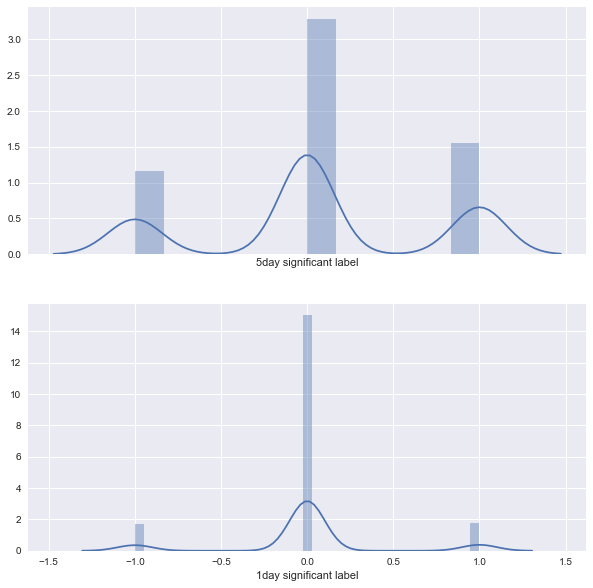

In [18]:
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 10))
sns.distplot(merged_data['5day significant label'], ax=ax1)
sns.distplot(merged_data['1day significant label'], ax=ax2)

In [19]:
merged_data['5day significant label'].value_counts()

 0    758
 1    359
-1    267
Name: 5day significant label, dtype: int64

In [20]:
X = merged_data['rawText']
y = merged_data['5day significant label'] + 1

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Tf-Idf and DNN model

In [22]:
tfidf = TfidfVectorizer(max_df=0.35, min_df=2, ngram_range=(1,3), stop_words='english')

In [23]:
tfidf_vectors = tfidf.fit_transform(X_train)

In [ ]:
classifier = learn.DNNClassifier(hidden_units=[60, 40, 20], n_classes=3, 
                                 feature_columns=[tf.contrib.layers.real_valued_column("", dimension=tfidf_vectors.shape[1])])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_master': '', '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_evaluation_master': '', '_num_ps_replicas': 0, '_task_id': 0, '_tf_random_seed': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_type': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000021951850C88>, '_keep_checkpoint_max': 5, '_is_chief': True, '_save_checkpoints_steps': None, '_environment': 'local', '_save_checkpoints_secs': 600}


In [ ]:
classifier.fit(tfidf_vectors.todense(), y_train, batch_size=20, steps=600)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\neural\AppData\Local\Temp\tmpyh_akjze\model.ckpt.
INFO:tensorflow:step = 1, loss = 1.09857
INFO:tensorflow:global_step/sec: 0.659473
INFO:tensorflow:step = 101, loss = 1.03015
INFO:tensorflow:global_step/sec: 0.875084
INFO:tensorflow:step = 201, loss = 1.08727


In [ ]:
y_predicted = list(classifier.predict(tfidf.transform(X_test).todense()))

#### Confusion matrix
By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` but
predicted to be in group :math:`j`.

In [ ]:
cm = confusion_matrix(y_test, y_predicted)

In [ ]:
sns.heatmap(cm, cmap='magma', annot=True, xticklabels=['-1', '0', '1'], yticklabels=['-1', '0', '1'])

In [ ]:
cr = classification_report(y_test, y_predicted)
print(cr)

In [ ]:
accuracy_score(y_test, y_predicted)

# Playground

In [ ]:
indices = np.argsort(tfidf.idf_)[::-1]
features = tfidf.get_feature_names()
top_n = 10
top_features = [features[i] for i in indices[:top_n]]
print(top_features)